INFO:root:Main image loaded successfully.
INFO:root:Processing template: fusedSwitch.png
INFO:root:Using threshold 0.995 for template fusedSwitch.png
INFO:root:Processing template: meter.png
INFO:root:Using threshold 0.95 for template meter.png
INFO:root:Processing template: xfmr.png
INFO:root:Using threshold 0.909 for template xfmr.png
INFO:root:Processing template: panel.png
INFO:root:Using threshold 0.9335 for template panel.png
INFO:root:Processing template: cb.png
INFO:root:Using threshold 0.935 for template cb.png
INFO:root:Annotated image saved as 'results.png'
INFO:root:Bar graph saved as 'annotation_counts.png'


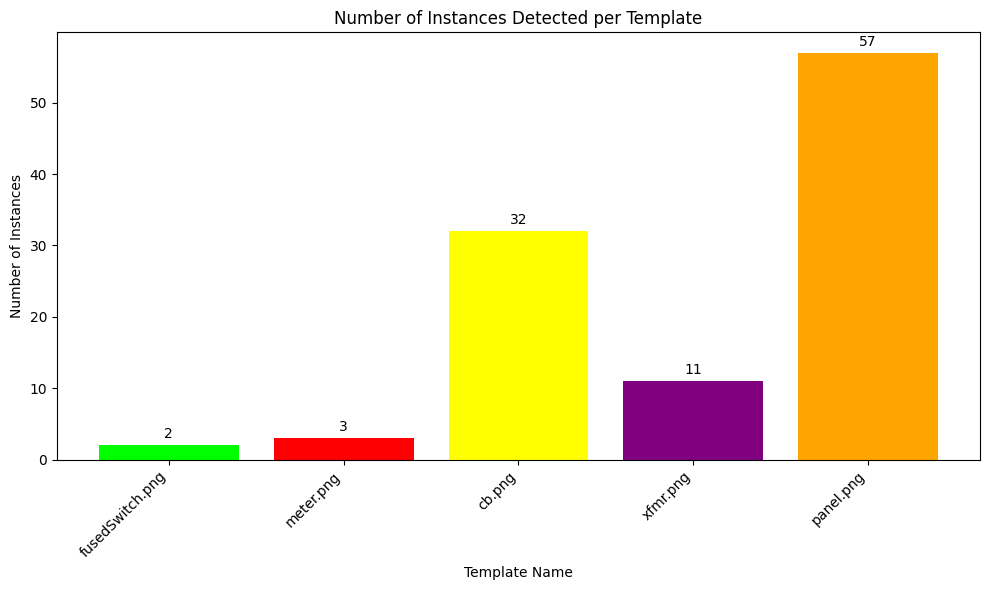

In [1]:
import os
import numpy as np
import cv2 as cv
import csv
import logging
import matplotlib.pyplot as plt

# Set up logging
logging.basicConfig(level=logging.INFO)

dir = 'experiment1'
base_filename = 'base.jpg'

# Predefined bright colors
BRIGHT_COLORS = [
    [0, 255, 0],      # Bright Green
    [255, 0, 0],      # Bright Red
    [128, 0, 128],    # Bright Purple
    [255, 165, 0],    # Bright Orange
    [255, 255, 0],    # Bright Yellow
    [0, 0, 255]       # Bright Blue
]

def apply_threshold(image, threshold_value=127):
    _, binary_image = cv.threshold(image, threshold_value, 255, cv.THRESH_BINARY)
    return binary_image

def rotate_image_90(image):
    return cv.rotate(image, cv.ROTATE_90_CLOCKWISE)

def rotate_image_270(image):
    return cv.rotate(image, cv.ROTATE_90_COUNTERCLOCKWISE)

def rotate_image_180(image):
    return cv.rotate(image, cv.ROTATE_180)

def flip_image(image):
    return cv.flip(image, 1)

def process_template_matching(img_gray_thresh, template_thresh, matching_threshold, template_name):
    boxes = []
    scores = []  # Store the scores for NMS
    transformations = [lambda x: x, flip_image, rotate_image_90, rotate_image_180, rotate_image_270]

    for transform in transformations:
        transformed_template = transform(template_thresh)
        res = cv.matchTemplate(img_gray_thresh, transformed_template, cv.TM_CCORR_NORMED)

        loc = np.where(res >= matching_threshold)
        w, h = transformed_template.shape[::-1]
        for pt in zip(*loc[::-1]):
            boxes.append([pt[0], pt[1], pt[0] + w, pt[1] + h])
            scores.append(res[pt[::-1]])

    return boxes, scores, template_name

def non_max_suppression(boxes, scores, overlapThresh):
    if len(boxes) == 0:
        return [], []

    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    pick = []
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(scores)

    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        overlap = (w * h) / area[idxs[:last]]

        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlapThresh)[0])))

    return pick

def read_thresholds(csv_path):
    thresholds = {}
    with open(csv_path, mode='r') as file:
        reader = csv.reader(file)
        next(reader)  # Skip header
        for row in reader:
            thresholds[row[0]] = float(row[1])
    return thresholds

def main():
    base_dir = os.path.join(dir, base_filename)
    img_rgb = cv.imread(base_dir)
    assert img_rgb is not None, "file could not be read, check with os.path.exists()"
    logging.info("Main image loaded successfully.")

    img_gray = cv.cvtColor(img_rgb, cv.COLOR_BGR2GRAY)
    img_gray_thresh = apply_threshold(img_gray)

    template_dir = os.path.join(dir, 'templates')
    thresholds_dir = os.path.join(dir, 'thresholds.csv')
    thresholds = read_thresholds(thresholds_dir)
    all_boxes = []
    all_scores = []
    all_names = []
    template_colors = {}
    color_index = 0

    for template_file in os.listdir(template_dir):
        template_path = os.path.join(template_dir, template_file)
        template = cv.imread(template_path, cv.IMREAD_GRAYSCALE)
        if template is None:
            logging.error(f"Failed to load template: {template_path}")
            continue  # Skip this template

        logging.info(f"Processing template: {template_file}")

        template_colors[template_file] = BRIGHT_COLORS[color_index % len(BRIGHT_COLORS)]
        color_index += 1

        template_thresh = apply_threshold(template)
        matching_threshold = thresholds.get(template_file, 0.90)  # Default threshold if not specified

        # Log the threshold being used for each template
        logging.info(f"Using threshold {matching_threshold} for template {template_file}")

        boxes, scores, template_name = process_template_matching(img_gray_thresh, template_thresh, matching_threshold, template_file)
        all_boxes.extend(boxes)
        all_scores.extend(scores)
        all_names.extend([template_name] * len(boxes))

    all_boxes_np = np.array(all_boxes)
    all_scores_np = np.array(all_scores)
    selected_indices = non_max_suppression(all_boxes_np, all_scores_np, 0.5)

    selected_boxes = all_boxes_np[selected_indices]
    selected_names = [all_names[i] for i in selected_indices]

    annotation_counts = {}
    for box, name in zip(selected_boxes, selected_names):
        x1, y1, x2, y2 = box
        color = template_colors[name]
        cv.rectangle(img_rgb, (x1, y1), (x2, y2), color, 3)  # Thickness set to 3

        if name not in annotation_counts:
            annotation_counts[name] = 0
        annotation_counts[name] += 1

    cv.imwrite(os.path.join(dir, 'results.png'), img_rgb)
    logging.info("Annotated image saved as 'results.png'")

    # Create and save the bar graph with matching colors and counts
    plt.figure(figsize=(10, 6))
    bar_colors = [tuple(np.array(template_colors[template_name]) / 255.0) for template_name in annotation_counts.keys()]
    bars = plt.bar(annotation_counts.keys(), annotation_counts.values(), color=bar_colors)
    plt.xlabel('Template Name')
    plt.ylabel('Number of Instances')
    plt.title('Number of Instances Detected per Template')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # Add counts on top of the bars
    for bar in bars:
        height = bar.get_height()
        plt.annotate('{}'.format(height),
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom')

    plt.savefig(os.path.join(dir, 'annotation_counts.png'))
    logging.info("Bar graph saved as 'annotation_counts.png'")

if __name__ == "__main__":
    main()
